# Used Car Dataset Analysis

1. In this project I am going to predict the price of used cars using Random Forest,Linear regression and Decision tree

2.Data is collected from Kaggle

3.Used Python for Data Clleaning,Data pre-processing,seaborn and Matplotlib for Visualisation,Scikit Learn for building the machine learing models.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
data=pd.read_csv('vehicles.csv')

In [3]:
data.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7184791621,https://duluth.craigslist.org/ctd/d/duluth-200...,duluth / superior,https://duluth.craigslist.org,6995,2000.0,gmc,new sierra 1500,excellent,8 cylinders,...,4wd,NaN,NaN,red,https://images.craigslist.org/00n0n_f06ykBMcdh...,2000 *** GMC New Sierra 1500 Ext Cab 157.5 WB...,NaN,mn,46.8433,-92.2550
1,7184773187,https://duluth.craigslist.org/cto/d/saginaw-20...,duluth / superior,https://duluth.craigslist.org,8750,2013.0,hyundai,sonata,excellent,4 cylinders,...,fwd,NaN,NaN,grey,https://images.craigslist.org/00d0d_kgZ6xoeRw2...,For Sale: 2013 Hyundai Sonata GLS - $8750. O...,NaN,mn,46.9074,-92.4638
2,7193375964,https://newhaven.craigslist.org/cto/d/stratfor...,new haven,https://newhaven.craigslist.org,10900,2013.0,toyota,prius,good,4 cylinders,...,fwd,NaN,NaN,blue,https://images.craigslist.org/00d0d_3sHGxPbY2O...,2013 Prius V Model Two. One owner—must sell my...,NaN,ct,41.1770,-73.1336
3,7195108810,https://albuquerque.craigslist.org/cto/d/albuq...,albuquerque,https://albuquerque.craigslist.org,12500,2003.0,mitsubishi,lancer,good,4 cylinders,...,4wd,mid-size,sedan,grey,https://images.craigslist.org/00m0m_4a8Pb6JbMG...,"2003 Mitsubishi Lancer Evolution, silver. Abo...",NaN,nm,35.1868,-106.6650
4,7184712241,https://duluth.craigslist.org/ctd/d/rush-city-...,duluth / superior,https://duluth.craigslist.org,16995,2007.0,gmc,sierra classic 2500hd,good,8 cylinders,...,4wd,full-size,truck,white,https://images.craigslist.org/01414_g093aPtSMW...,"**Bad Credit, No Credit... No Problem!**2007 G...",NaN,mn,45.6836,-92.9648


In [4]:
data.shape

(423857, 25)

In [5]:
new_data=data.copy()

In [6]:
new_data.shape

(423857, 25)

## Data Cleaning

In [9]:
#re-naming the columns
new_data.rename({'make':'model','odometer':'mileage'},axis=1,inplace=True)

In [10]:
# Lets drop the columns that are not useful for the car price prediction
drop_columns=['region_url','url','lat','long','image_url','vin','region','id','county','state']
new_data=new_data.drop(drop_columns,axis=1)
new_data.shape

KeyError: "['region_url' 'url' 'lat' 'long' 'image_url' 'vin' 'region' 'id' 'county'\n 'state'] not found in axis"

In [15]:
#lets drop the columns where price of the car is more than 2.5 million dollars because high end used cars like ferrari, porsche costs less than that
new_data = new_data.drop(new_data[new_data.price > 250000].index)
new_data.shape

(310224, 14)

In [16]:
# Lets drop the columns where year is less than 1990 and greater than 2019
new_data=new_data[(new_data['year']>1990)&(new_data['year']<2020)]
new_data.index=range(len(new_data))
new_data.shape

KeyError: 'year'

In [17]:
#finding the length of description of each car
new_data.dropna(subset=['description'],inplace=True)# dropping the null values in desc column
new_data.index=range(len(new_data))
del new_data['description']

KeyError: ['description']

In [18]:
#finding the age of car
from datetime import datetime
current_year=datetime.now().year
new_data['Age']=current_year-new_data['year']
del new_data['year']

KeyError: 'year'

In [19]:
#removing the cylinders in the columns and converting into float
new_data.cylinders=new_data.cylinders.apply(lambda x:x if str(x).lower()[-1]=='o'or str(x).lower()[-1]=='n' else str(x).lower().replace('cylinders',''))
new_data.cylinders=pd.to_numeric(new_data.cylinders,errors='coerce')
new_data.cylinders.fillna(new_data.cylinders.median(),inplace=True)

In [20]:
# Lets drop the rows where has atleast 3 NaN values
new_data.dropna(thresh=13,axis=0,inplace=True)
new_data.shape

(122345, 14)

In [21]:
#dropping the duplicates in the data
new_data.drop_duplicates(keep='first',inplace=True)
new_data.index=range(len(new_data))
new_data.shape

(92803, 14)

In [22]:
#fixing the spelling errors
new_data.manufacturer=new_data.manufacturer.apply(lambda x:x.replace('porche','porsche')if x=='porche'else x)

In [23]:
#creating new dataframe to find the size of each car in order to fill the null vlaues in the size feature of same car
new=new_data.sort_values(by=['size','manufacturer','type'])
new.drop_duplicates(subset=['model','type'],keep='first',inplace=True)
new.index=range(len(new))

In [24]:
new.dropna(subset=['size','model'],inplace=True)
new.index=range(len(new))

In [25]:
#dictionary that contain size of each car
size=dict(zip(new['model'],new['size']))
for i in range(len(new_data)):
    if str(new_data['size'][i]).lower()[0]=='n' and (new_data['model'][i]in size.keys()):
        new_data['size'][i]=size[new_data['model'][i]]

In [26]:
#Adding the manufacturers name to list from the dataset and adding few more manufacturer after looking the make column in dataset
manuf=[]
for i in new_data.manufacturer.value_counts().index:
    manuf.append(i)
manuf.append('Tesla')
manuf.append('Rolls-Royce')
manuf.append('genisis')

In [27]:
#Replace then nan values in the manufaturer column based on the model column
#From make coumn we can identify manufaturer of the car as it sometimes contain the manufacturer name in it
d=new_data['manufacturer']
m=new_data['model']
for i in range(len(new_data)):
    if str(d[i]).lower()[0]=='n':
        for x in str(m[i]).lower().split():
            for mm in manuf:
                if(len(x)>4)&(x[:4]==mm.lower()[:4]):
                    new_data['manufacturer'][i]=mm
                elif(x[:3]==mm.lower()[:3])&(x[:1]==mm.lower()[:-1]):
                    new_data['manufacturer'][i]=mm

In [28]:
#dropping the null values
new_data.dropna(subset=['transmission','type','manufacturer','model','fuel','mileage','title_status','paint_color','drive','size','condition'],inplace=True)
new_data.index=range(len(new_data))
new_data.shape

(68144, 14)

In [29]:
#Function to remove the outliers in the data
def outlier_removal(x):
    for i in x:
        z_score_od=np.abs(stats.zscore(new_data[i]))
        outliers=np.where(z_score_od>3)
        new_data.drop(new_data.index[[i for i in outliers[0]]],inplace=True)
        new_data.index=range(len(new_data))
outlier_removal(new_data._get_numeric_data().columns)

price of car cant be zero so we are eliminating the price less than 50 dollars.Some  people mentioned very less price and they will reveal the price directly to customer      while buying and bargain later.


In [30]:
new_data=new_data[new_data['price']>50]
new_data.index=range(len(new_data))
new_data.shape

(63703, 14)

In [31]:
#shifting the age to new place
new_data.insert(1,'age',new_data['Age'])
del new_data['Age']

In [32]:
new_data.columns

Index(['price', 'age', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'mileage', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color'],
      dtype='object')

In [33]:
new_data.columns

Index(['price', 'age', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'mileage', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color'],
      dtype='object')

In [34]:
new_data.condition.value_counts()

excellent    31009
good         23078
like new      6559
fair          2687
salvage        195
new            175
Name: condition, dtype: int64

In [35]:
new_data.title_status.value_counts()

clean         59751
rebuilt        2041
lien            931
salvage         910
missing          50
parts only       20
Name: title_status, dtype: int64

In [36]:
#changing the 'like new' to 'new'
new_data.condition=new_data.condition.apply(lambda x:x.replace('like new','new')if x=='like new'else x)

In [37]:
#Finding the models of car which has fewer data
other_models=new_data.model.value_counts().index[new_data.model.value_counts().values<5]

In [38]:
#Fuction replaces the less frequent models of car to other_models category
def model_edit(model_list,data):
    for i in range(len(data)):
        if data[i] in model_list:
            data[i]='other_models'
model_edit(other_models,new_data['model'])

In [39]:
#changing the datatype from float to int
new_data['age']=new_data['age'].astype(int)
new_data['mileage']=new_data['mileage'].astype(int)
new_data['cylinders']=new_data['cylinders'].astype(int)

In [40]:
new_data.head()

,price,age,manufacturer,model,condition,cylinders,fuel,mileage,title_status,transmission,drive,size,type,paint_color
0,16995,13,gmc,other_models,good,8,diesel,254217,clean,automatic,4wd,full-size,truck,white
1,13995,8,ford,f-150,good,6,gas,188406,clean,automatic,4wd,full-size,truck,grey
2,7995,10,chevrolet,equinox,good,4,gas,108124,clean,automatic,4wd,full-size,SUV,grey
3,8995,9,chevrolet,traverse,good,6,gas,178054,clean,automatic,4wd,full-size,SUV,white
4,10995,6,ford,explorer,good,6,gas,170259,clean,automatic,4wd,full-size,SUV,white


In [41]:
new_data.dtypes

price            int64
age              int32
manufacturer    object
model           object
condition       object
cylinders        int32
fuel            object
mileage          int32
title_status    object
transmission    object
drive           object
size            object
type            object
paint_color     object
dtype: object

In [42]:
new_data.isnull().sum()

price           0
age             0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
mileage         0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
dtype: int64

In [43]:
new_data.describe(include='all')

,price,age,manufacturer,model,condition,cylinders,fuel,mileage,title_status,transmission,drive,size,type,paint_color
count,63703.000000,63703.000000,63703,63703,63703,63703.000000,63703,63703.000000,63703,63703,63703,63703,63703,63703
unique,NaN,NaN,38,1810,5,NaN,5,NaN,6,3,3,4,13,12
top,NaN,NaN,ford,other_models,excellent,NaN,gas,NaN,clean,automatic,fwd,full-size,sedan,white
freq,NaN,NaN,10928,9157,31009,NaN,59229,NaN,59751,57844,28290,30690,20088,13903
mean,11043.777483,10.327850,NaN,NaN,NaN,5.728302,NaN,116498.449382,NaN,NaN,NaN,NaN,NaN,NaN
std,8142.322622,5.622584,NaN,NaN,NaN,1.498335,NaN,62496.919573,NaN,NaN,NaN,NaN,NaN,NaN
min,68.000000,1.000000,NaN,NaN,NaN,3.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,4999.000000,6.000000,NaN,NaN,NaN,4.000000,NaN,72000.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,8900.000000,10.000000,NaN,NaN,NaN,6.000000,NaN,114085.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,14990.000000,14.000000,NaN,NaN,NaN,6.000000,NaN,156660.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
new_data.to_csv('Final_data.csv',index=False)

In [45]:
Final_data=pd.read_csv('Final_data.csv')

In [46]:
def unique_val(data,columns):
    unique=[]
    for col in columns:
        u=data[col].nunique()
        unique.append((col,u,data[col].value_counts(normalize=True).values[0]*100))
    return unique

In [47]:
unique=unique_val(Final_data,Final_data.columns)

In [48]:
unique_values=pd.DataFrame(unique,columns=['Features','unique_values','Largest category percentage']).sort_values('Largest category percentage',ascending=False)
unique_values

,Features,unique_values,Largest category percentage
8,title_status,6,93.796211
6,fuel,5,92.976783
9,transmission,3,90.802631
4,condition,5,48.677456
11,size,4,48.176695
10,drive,3,44.409211
5,cylinders,6,42.676169
12,type,13,31.533837
13,paint_color,12,21.824718
2,manufacturer,38,17.154608


In [49]:
imbalanced_columns=unique_values[unique_values['Largest category percentage']>80]
imbalanced_columns

,Features,unique_values,Largest category percentage
8,title_status,6,93.796211
6,fuel,5,92.976783
9,transmission,3,90.802631


In [50]:
Final_data1=Final_data.drop(columns=imbalanced_columns.Features)

In [51]:
Final_data1.shape

(63703, 11)

In [52]:
Final_data.columns

Index(['age', 'price', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'mileage', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color'],
      dtype='object')

## Visualisation

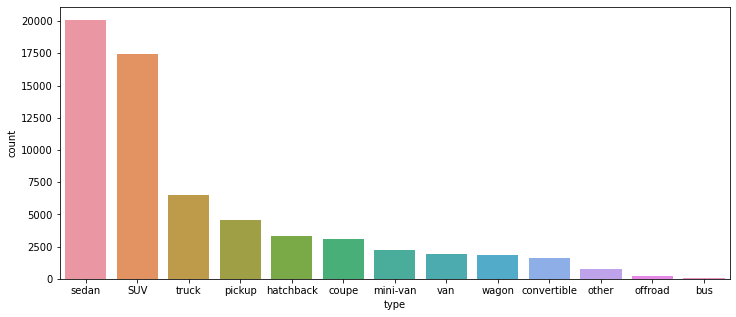

In [52]:
plt.figure(figsize=(12,5))
sns.countplot(x='type',order=Final_data['type'].value_counts().index,data=Final_data)

People are selling the used Sedan the most followed by SUV and Trucks.They are very less likely to sell Bus and off-road vehicles because dont but those often

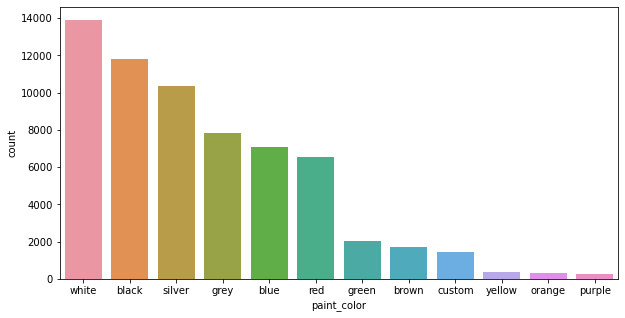

In [53]:
plt.figure(figsize=(10,5))
sns.countplot(x='paint_color',order=Final_data['paint_color'].value_counts().index,data=Final_data)

1.We can see that people are buying used cars with common colors(white,grey,black,silver,blue,red) than not common colors

2.Not Common colors (purple, orange, green etc) are mostly luxury cars which are too expensive

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 <a list of 38 Text major ticklabel objects>)

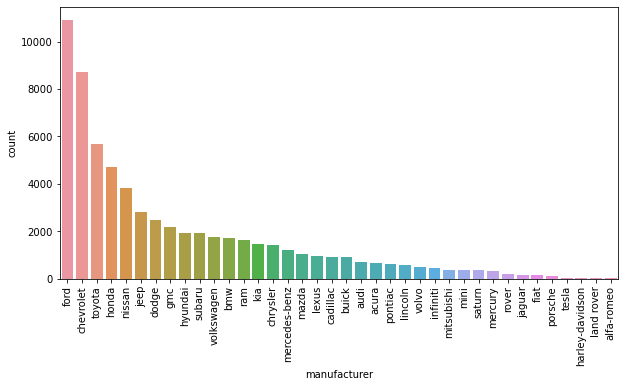

In [54]:
plt.figure(figsize=(10,5))
sns.countplot(x='manufacturer',order=Final_data['manufacturer'].value_counts().index,data=Final_data)
plt.xticks(rotation=90)

Ford, Toyota, Chevrolet and Honda manufacturer cover most of the used cars because they are cheap and good than other manufacturers like Ferrari, Rolls-Royce and Hennessey

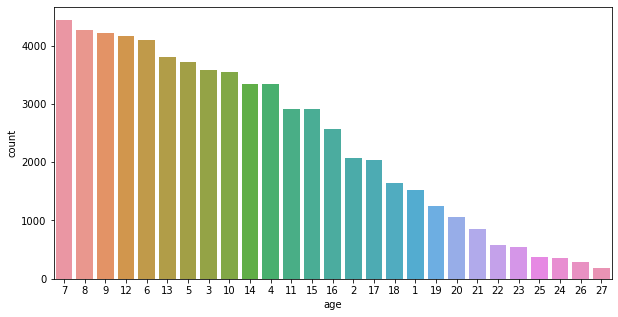

In [55]:
plt.figure(figsize=(10,5))
sns.countplot(x='age',order=Final_data['age'].value_counts().index,data=Final_data)

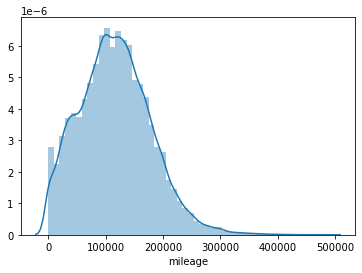

In [56]:
sns.distplot(Final_data['mileage'])

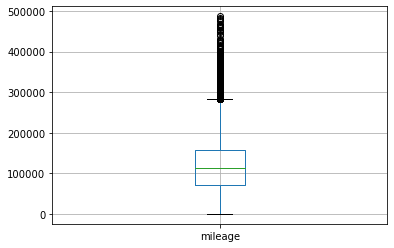

In [57]:
Final_data.boxplot('mileage')

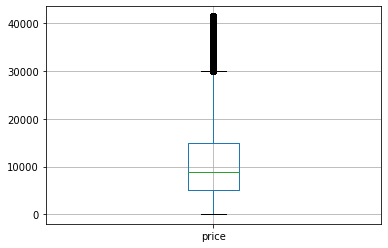

In [58]:
Final_data.boxplot('price')

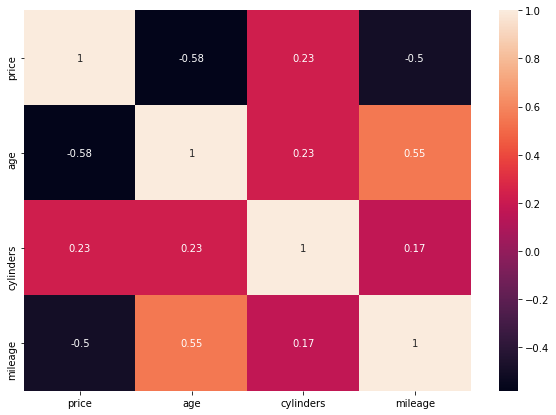

In [59]:
plt.figure(figsize = (10,7))
corr = Final_data.corr()
sns.heatmap(corr, annot = True)

## Model building

In [60]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization

In [62]:
F1=pd.get_dummies(Final_data)
F1.head()

,price,age,cylinders,mileage,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,...,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
0,16995,13,8,254217,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,13995,8,6,188406,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,7995,10,4,108124,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,8995,9,6,178054,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,10995,6,6,170259,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [63]:
X=F1.drop('price',axis=1)
y=F1['price']

In [64]:
X=X.values
X

array([[    13,      8, 254217, ...,      0,      1,      0],
       [     8,      6, 188406, ...,      0,      0,      0],
       [    10,      4, 108124, ...,      0,      0,      0],
       ...,
       [    18,      6,  58000, ...,      0,      0,      0],
       [    14,      6, 159980, ...,      0,      0,      0],
       [    17,      8, 160000, ...,      0,      0,      0]], dtype=int64)

In [65]:
y=y.values.ravel()
y

array([16995, 13995,  7995, ...,  4800,  1600,  9000], dtype=int64)

In [66]:
print(X.shape)
print(y.shape)

(63703, 1902)
(63703,)


In [67]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=42)

In [68]:
linreg=LinearRegression()
lasso=Lasso()
ridge=Ridge()
Dtree=DecisionTreeRegressor()
rfreg=RandomForestRegressor()

In [69]:
#parameters
kfold=KFold(n_splits=5)
scoring='r2'
algo_list=list([linreg,lasso,ridge,Dtree,rfreg])
algo_name=list(['Linear regression','lasso','ridge','Decision tree','Random forest'])

In [70]:
# Buliding models on various algorithms
def model_building(algo,X,y,fold,scoring):
    algo_score=[]
    for i in algo:
        score=cross_val_score(i,X,y,cv=fold,scoring=scoring).mean()
        algo_score.append(score)
    return algo_score

In [71]:
import datetime as dt
x=dt.datetime.now()
print(x)

2020-11-24 22:23:54.945022


In [72]:
result=model_building(algo_list,X_train,y_train,kfold,scoring)

In [73]:
cv_score=dict(zip(algo_name,result))

In [74]:
cv_score

{'Linear regression': -133883685.45906758,
 'lasso': 0.7207750168116152,
 'ridge': 0.7398725342716435,
 'Decision tree': 0.6682994992749801,
 'Random forest': 0.8129496109041705}

## Hyperparameter tuning

In [85]:
def RF_optimizer(bootstrap,min_samples_leaf,n_estimators):
    algo_performance=[]
    m=RandomForestRegressor(bootstrap=bootstrap,min_samples_leaf=int(round(min_samples_leaf)),n_estimators=int(round(n_estimators)))
    m.fit(X_train,y_train)
    y_pred=m.predict(X_test)
    r_sq=r2_score(y_test,y_pred)
    algo_performance.append(r_sq)
    return np.mean(algo_performance)

In [86]:
def GBM_optimizer(learning_rate,max_depth,n_estimators,min_samples_split):
    algo_performance = []
    
    m=GradientBoostingRegressor(learning_rate=learning_rate,max_depth=int(round(max_depth)),n_estimators=int(round(n_estimators)),min_samples_split=int(round(min_samples_split)))    
    m.fit(X_train,y_train)
    y_pred =m.predict(X_test)
    r_sq = r2_score(y_test, y_pred)
    algo_performance.append(r_sq)
    return np.mean(algo_performance)

In [87]:
def lasso_optimizer(alpha):
    algo_performance = []
    m=Lasso(alpha = alpha)
    m.fit(X_train,y_train)
    y_pred =m.predict(X_test)
    r_sq = r2_score(y_test, y_pred)
    algo_performance.append(r_sq)
    return np.mean(algo_performance)

In [88]:
def ridge_optimizer(alpha):
    algo_performance = []
    m=Ridge(alpha = alpha)
    m.fit(X_train,y_train)
    y_pred =m.predict(X_test)
    r_sq = r2_score(y_test, y_pred)
    algo_performance.append(r_sq)
    return np.mean(algo_performance)

In [89]:
GBM_bounds={'learning_rate':(0.08,0.12),'max_depth':(1,5),'n_estimators':(70,130),'min_samples_split':(2,4)}
RF_bounds={'bootstrap':(True,False),'min_samples_leaf':(1,20),'n_estimators':(100,200)}

In [90]:
lasso_params = {'alpha':(0.005, 0.06)}
ridge_params = {'alpha':(550,650)}

In [96]:
optimizers=[GBM_optimizer]
bounds=[GBM_bounds]


In [97]:
optimizers1=[lasso_optimizer,ridge_optimizer]
bounds1=[lasso_params,ridge_params]

In [98]:
import datetime as dt
x = dt.datetime.now()
print(x)

2020-11-25 10:21:51.834795


In [99]:
def tuning(optimizers,bounds):
    hyperparameter={}
    for i in range(len(optimizers)):
        print(optimizers[i].__name__)
        temp=BayesianOptimization(f=optimizers[i],pbounds=bounds[i],random_state=1)
        temp.maximize(n_iter=5)
        hyperparameter[optimizers[i]]=temp.max
    return hyperparameter

tuning(optimizers,bounds)

GBM_optimizer
|   iter    |  target   | learni... | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.798    |  0.09668  |  3.881    |  2.0      |  88.14    |
|  2        |  0.6399   |  0.08587  |  1.369    |  2.373    |  90.73    |
|  3        |  0.7876   |  0.09587  |  3.155    |  2.838    |  111.1    |
|  4        |  0.8144   |  0.08818  |  4.512    |  2.055    |  110.2    |
|  5        |  0.7788   |  0.09669  |  3.235    |  2.281    |  81.89    |
|  6        |  0.8011   |  0.08833  |  3.868    |  2.718    |  108.3    |
|  7        |  0.8134   |  0.12     |  5.0      |  2.0      |  85.51    |
|  8        |  0.8169   |  0.12     |  5.0      |  2.0      |  103.4    |
|  9        |  0.6487   |  0.0834   |  1.173    |  2.213    |  103.3    |
|  10       |  0.7746   |  0.08365  |  3.323    |  3.983    |  85.76    |


{<function __main__.GBM_optimizer(learning_rate, max_depth, n_estimators, min_samples_split)>: {'target': 0.8169171586988837,
  'params': {'learning_rate': 0.12,
   'max_depth': 5.0,
   'min_samples_split': 2.0,
   'n_estimators': 103.39860148101036}}}

In [100]:
import datetime as dt
x = dt.datetime.now()
print(x)

2020-11-25 11:41:42.275055


In [101]:
def tuning1(optimizers,bounds):
    hyperparameter={}
    for i in range(len(optimizers)):
        print(optimizers[i].__name__)
        temp=BayesianOptimization(f=optimizers[i],pbounds=bounds[i],random_state=1)
        temp.maximize(n_iter= 15)
        hyperparameter[optimizers[i]]=temp.max
    return hyperparameter

In [102]:
tuning1(optimizers1,bounds1)

lasso_optimizer
|   iter    |  target   |   alpha   |
-------------------------------------
|  1        |  0.7451   |  0.02794  |
|  2        |  0.7454   |  0.04462  |
|  3        |  0.7443   |  0.005006 |
|  4        |  0.7449   |  0.02163  |
|  5        |  0.7446   |  0.01307  |
|  6        |  0.7457   |  0.06     |
|  7        |  0.7456   |  0.05782  |
|  8        |  0.7456   |  0.05782  |
|  9        |  0.7456   |  0.05782  |
|  10       |  0.7457   |  0.05999  |
|  11       |  0.7457   |  0.05999  |
|  12       |  0.7457   |  0.05999  |
|  13       |  0.7457   |  0.05999  |
|  14       |  0.7457   |  0.05999  |
|  15       |  0.7457   |  0.05999  |
|  16       |  0.7457   |  0.05999  |
|  17       |  0.7457   |  0.05999  |
|  18       |  0.7457   |  0.05999  |
|  19       |  0.7457   |  0.05999  |
|  20       |  0.7457   |  0.05999  |
ridge_optimizer
|   iter    |  target   |   alpha   |
-------------------------------------
|  1        |  0.6927   |  591.7    |
|  2        |  0.6

{<function __main__.lasso_optimizer(alpha)>: {'target': 0.7456658580183635,
  'params': {'alpha': 0.06}},
 <function __main__.ridge_optimizer(alpha)>: {'target': 0.6935952581942124,
  'params': {'alpha': 550.0}}}

In [103]:
import datetime as dt
x = dt.datetime.now()
print(x)

2020-11-25 11:55:41.907836


## Testing

In [104]:
def prediction(algo,X_train, y_train, X_test, y_test):
    r2_score1 = []
    for i in algo:
        reg = i.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_score1.append(r2)
    return r2_score1

In [105]:
import datetime as dt
x = dt.datetime.now()
print(x)

2020-11-25 11:56:17.187108


In [106]:
p = prediction(algo_list, X_train, y_train, X_test, y_test)

In [107]:
test_score = dict(zip(algo_name,p))

In [108]:
#after removing imbalanced columns
test_score

{'Linear regression': 0.7440988892929403,
 'lasso': 0.7266239361649125,
 'ridge': 0.7463507594491088,
 'Decision tree': 0.6960463439030466,
 'Random forest': 0.8219976458932473}

In [109]:
#final model with Random forest.
rfreg.fit(X, y)

RandomForestRegressor()

In [110]:
ridge.fit(X, y)

Ridge()

In [111]:
lasso.fit(X,y)

Lasso()

In [112]:
import datetime as dt
x = dt.datetime.now()
print(x)

2020-11-25 12:53:17.467467


## Prediction of new data

In [113]:
X1=F1.drop('price',axis=1)

In [114]:
X1.columns

Index(['age', 'cylinders', 'mileage', 'manufacturer_acura',
       'manufacturer_alfa-romeo', 'manufacturer_audi', 'manufacturer_bmw',
       'manufacturer_buick', 'manufacturer_cadillac', 'manufacturer_chevrolet',
       ...
       'paint_color_brown', 'paint_color_custom', 'paint_color_green',
       'paint_color_grey', 'paint_color_orange', 'paint_color_purple',
       'paint_color_red', 'paint_color_silver', 'paint_color_white',
       'paint_color_yellow'],
      dtype='object', length=1902)

In [115]:
cols=[]
for i in range(len(X1.columns)):
    if i<4:
        cols.append(X1.columns[i])
    elif(i>2629 and i<2636):
        col=X1.columns[i].split('_')[2]
        cols.append(col)
    else:
        col=X1.columns[i].split('_')[1]
        cols.append(col)

In [116]:
# predicting the price on new data
def predict_price(cat_cols,numeric_cols,Model):    
    x = np.zeros(len(X1.columns))
    for i in range(len(numeric_cols)):
        x[i] = numeric_cols[i]
    for i in cat_cols:
        if i in X1.columns:
            loc_index = np.where(X1.columns==i)[0][0]
            x[loc_index] = 1
        else:
            pass
    
    return Model.predict([x])[0]

In [117]:
# cat_cols = [car manufacturer name, model name of car,drive,fuel,transmission,size,type,paint_color ]
cat_cols = ['manufacturer_ford','model_f-150','drive_4wd','fuel_gas','condition_new','title_status_clean','transmission_automatic','type_truck','size_full-size','paint_color_blue']
# numeric_cols = ['age', 'cylinders', 'mileage']
numeric_cols = [25,8,101025]

In [118]:
# prediction using Random Forest model
predict_price(cat_cols,numeric_cols,rfreg)

14160.56

In [119]:
# prediction using linear regression model
predict_price(cat_cols,numeric_cols,linreg)

7119.551003135788

In [120]:
# prediction using ridge regression model
predict_price(cat_cols,numeric_cols,ridge)

6995.153148290268

In [121]:
# prediction using Lass0 regression model
predict_price(cat_cols,numeric_cols,lasso)

7341.730155276262

In [122]:
import pickle
with open('ridge_car_price_model1.pickle','wb') as f:
    pickle.dump(ridge,f)

In [123]:
with open('lasso_car_price_model1.pickle','wb') as f:
    pickle.dump(lasso,f)

In [124]:
with open('rf_car_price_model.pickle1','wb') as f:
    pickle.dump(rfreg,f)

In [125]:
import json
columns = {
    'data_columns' : [col for col in cols]
}
with open("columns_final1.json","w") as f:
    f.write(json.dumps(columns))